# Identificação e Mensuração de Áreas Verdes

### Recorte de Imagens para Serem Rotuladas

---

De início, para rotular as imagens, implementa-se um algorítmo que detecte cores no espectro verde em imagens, de forma a identificar e mensurar as áreas verdes.

---


In [1]:
import os
from PIL import Image

def fragment_and_save_image(image_path, rows, cols, output_dir):

    # Listar arquivos na pasta
    archives = os.listdir(image_path)

    # Listar arquivos recortados
    archive_list = []

    # Abrir a pasta
    for n, archive in enumerate(archives):

        jpg = image_path + '/' + archive

        # Abrir a imagem
        image = Image.open(jpg)
        width, height = image.size

        # Calcular o tamanho de cada fragmento
        fragment_width = width // cols
        fragment_height = height // rows

        # Criar o diretório de saída se não existir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for i in range(rows):
            for j in range(cols):
                left = j * fragment_width
                upper = i * fragment_height
                right = (j + 1) * fragment_width
                lower = (i + 1) * fragment_height

                # Definindo número do recorte:
                n_r = os.listdir(f'{image_path}/')[n].split('.')[0]

                # Recortar o fragmento
                fragment = image.crop((left, upper, right, lower))

                # Adicionar arquivo recortado à lista
                archive_list.append(f'fragment_{n_r}_{i}_{j}.png')

                # Salvar o fragmento como arquivo PNG
                fragment_path = os.path.join(output_dir, f'fragment_{n_r}_{i}_{j}.png')
                fragment.save(fragment_path)

    return archive_list

In [2]:
if len(os.listdir('labels')) > 1000:
    archives = os.listdir('labels')

else:
    archives = fragment_and_save_image('features', 15, 15, 'labels')

### Funções para Visualização e Tratamento de Dados

##### Gráfico de Comparação

In [3]:
import cv2
import matplotlib.pyplot as plt

def graph_1(resized_image, title_1,
            green_mask, title_2,
            green_areas, title_3,
            size):

    # Visualizar a imagem segmentada e as áreas verdes

    plt.figure(figsize=size)

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(title_1, fontsize=8)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(green_mask, cmap='gray')
    plt.title(title_2, fontsize=8)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(green_areas, cv2.COLOR_BGR2RGB))
    plt.title(title_3, fontsize=8)
    plt.axis('off')

    plt.show()

##### Gráficos de Acurácia e Perda

In [4]:
def graph_2(history, metric):

    # Plot das curvas de treinamento
    plt.figure(figsize=(10, 4))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label='Treinamento')
    plt.plot(history.history['val_' + metric], label='Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treinamento')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

##### Gráfico de Confusão

##### Separação de Áreas Verdes

In [5]:
import numpy as np

def green_area(link):

    # Carregar a imagem
    image = cv2.imread(link)

    # Redimensionar a imagem para aceleração do processamento
    scale_percent = 50  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    # Converter a imagem para o espaço de cor HSV
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Definir intervalo de cor verde (na escala HSV)
    lower_green = np.array([30, 25, 25])
    upper_green = np.array([100, 255, 255])

    # Criar máscara para os pixels verdes
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Aplicar a máscara na imagem original
    green_areas = cv2.bitwise_and(resized_image, resized_image, mask=green_mask)

    return resized_image, green_mask, green_areas

##### Porcentagem das Áreas Verdes

In [6]:
def perc_green_area(green_areas):

    # Converter a imagem para RGB (apenas para visualização no matplotlib)
    image_rgb = cv2.cvtColor(green_areas, cv2.COLOR_BGR2RGB)

    # Converter a imagem para escala de cinza
    gray_image = cv2.cvtColor(green_areas, cv2.COLOR_BGR2GRAY)

    # Aplicar um limiar para detectar pixels pretos
    # Pixels pretos serão aqueles com valor 0 no limiar binário
    _, black_and_white_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY_INV)

    # Contar o número de pixels pretos
    num_black_pixels = np.sum(black_and_white_image == 255)
    total_pixels = black_and_white_image.size

    # Calcular a porcentagem de pixels pretos
    percentage_black = (num_black_pixels / total_pixels) * 100

    return image_rgb, gray_image, black_and_white_image, percentage_black

##### Teste das Funções

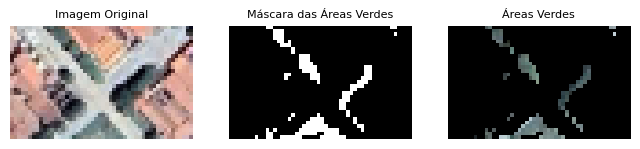

In [7]:
folder = 'labels/'

ir, gm, ga = green_area(f'{folder}fragment_areas_mescladas_urbana_5_6_4.png')

graph_1(ir, 'Imagem Original',
        gm, 'Máscara das Áreas Verdes',
        ga, 'Áreas Verdes',
        (8, 5))


O percentual de áreas verdes é de 9.55%



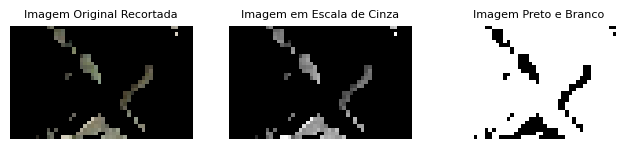

In [8]:
ic, gi, bwi, pb = perc_green_area(ga)

print(f'\nO percentual de áreas verdes é de {100 - pb:.2f}%\n')

graph_1(ic,  'Imagem Original Recortada',
        gi,  'Imagem em Escala de Cinza',
        bwi, 'Imagem Preto e Branco',
        (8, 5))

### Rotulando Imagens

---

Aplicando funções criadas em rotulação de imagens, a partir de áreas verdes e suas mensurações.

---

In [9]:
import pandas as pd

data = []

for n, arch in enumerate(archives):

    ir, _, ga = green_area(f'{folder}{arch}')

    ic, _, _, pb = perc_green_area(ga)

    data.append({
        'Arquivo': arch,
        'Área total': ir,
        'Área verde': ic,
        'Percentual de verde': (100 - pb)
    })

# Criar o DataFrame
df = pd.DataFrame(data)

# Exportando CSV do DataFrame
df.to_csv('test.csv', index=False)

# Visualização de DataFrame
df.head()

,Arquivo,Área total,Área verde,Percentual de verde
0,fragment_areas_mescladas_rurais_1_0_0.png,"[[[168, 165, 164], [181, 173, 180], [172, 165,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.129032
1,fragment_areas_mescladas_rurais_1_0_1.png,"[[[74, 76, 87], [111, 119, 127], [79, 83, 95],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.967742
2,fragment_areas_mescladas_rurais_1_0_10.png,"[[[99, 87, 99], [129, 124, 134], [123, 116, 12...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.000000
3,fragment_areas_mescladas_rurais_1_0_11.png,"[[[91, 80, 87], [35, 28, 34], [35, 28, 35], [6...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.000000
4,fragment_areas_mescladas_rurais_1_0_12.png,"[[[130, 132, 141], [129, 134, 141], [126, 126,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.258065


### Realizando predição de percentual de áreas verdes

##### Configurando dados

In [10]:
# Definindo DataFrame para predizer porcentagens
df_per = df[['Área total', 'Percentual de verde']]

# Embaralhando linhas
df_per = df_per.sample(frac=1, random_state=7).reset_index(drop=True)

# Separando dados de treino
df_train = df_per[:5000]

# Separando dados de teste
df_test = df_per[5000:5500]

# Visualizando dados de treino
df_train.head()

,Área total,Percentual de verde
0,"[[[152, 158, 164], [130, 135, 140], [130, 136,...",9.548387
1,"[[[85, 71, 30], [86, 73, 32], [85, 71, 30], [8...",86.645161
2,"[[[140, 137, 171], [154, 154, 188], [121, 123,...",34.451613
3,"[[[146, 152, 163], [171, 172, 182], [160, 152,...",1.612903
4,"[[[191, 190, 200], [201, 199, 208], [210, 204,...",0.967742


In [11]:
# Definir a dimensão desejada para as imagens
desired_size = (128, 128)  # Exemplo: 128x128 pixels

def resize_image(image_array, desired_size):
    image = Image.fromarray(np.uint8(image_array))
    image = image.resize(desired_size, Image.LANCZOS)
    return np.array(image)

# Extrair e redimensionar imagens
images = np.array([resize_image(np.array(img), desired_size) for img in df_train['Área total']])
labels = np.array(df_train['Percentual de verde'].tolist())

# Normalização das imagens (valores de pixels entre 0 e 1)
images = images / 255.0

# Normalização dos rótulos (escala entre 0 e 1)
labels = labels / 100.0

##### Arquitetura do modelo e treinamento dos dados

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Construção do modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(desired_size[0], desired_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Saída para regressão
])

# Compilação do modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)

# Avaliação do modelo
loss = model.evaluate(X_val, y_val)
print(f'\nValidation Loss: {loss}')

c:\Users\alexa\Desktop\Ícones\Estudos\UFRN\Mestrado\Códigos\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - loss: 0.8201 - mae: 0.4130 - val_loss: 0.0114 - val_mae: 0.0761
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - loss: 0.0083 - mae: 0.0611 - val_loss: 0.0029 - val_mae: 0.0333
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - loss: 0.0032 - mae: 0.0364 - val_loss: 0.0037 - val_mae: 0.0336
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - loss: 0.0043 - mae: 0.0414 - val_loss: 0.0010 - val_mae: 0.0209
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - loss: 0.0014 - mae: 0.0240 - val_loss: 0.0012 - val_mae: 0.0209
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0035 - mae: 0.0354 - val_loss: 0.0024 - val_mae: 0.0313
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - loss: 0.0047 - mae: 0.0436 - val_loss: 0.0038 - val_mae: 0.0394
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 324ms/step - loss: 0.0019 - mae: 0.0273 - val_loss: 7.9409e-04 - val_mae: 0.0169
Epoch 9/10
125/125 ━━━━━━━━━

##### Predição dos dados de teste

In [13]:
# Extraindo imagens teste e fazendo normalização
images_test = np.array([resize_image(np.array(img), desired_size) for img in df_test['Área total']])
images_test = images_test / 255.0

# Extraindo percentuais teste
labels_test = np.array(df_test['Percentual de verde'].tolist())

# Predizendo e revertendo a normalização das porcentagens
predictions = model.predict(images_test)
predictions = predictions * 100

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


##### Avaliação de acurácia do modelo

MAE : 3.0945
MSE : 19.5039
RMSE: 4.4163
R²  : 0.9864



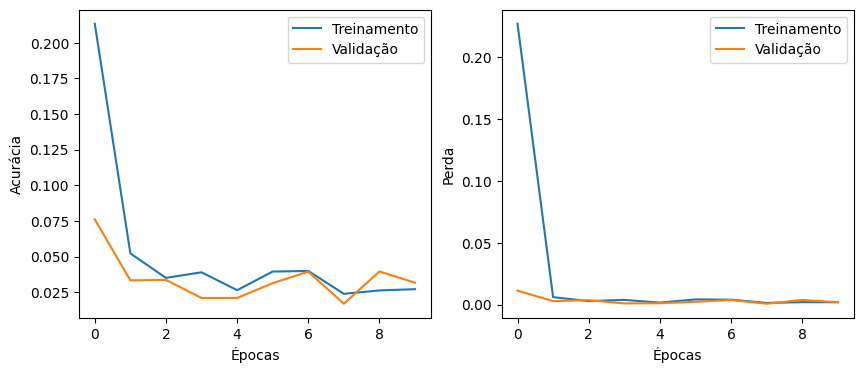

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcular o erro absoluto médio (Mean Absolute Error - MAE)
mae = mean_absolute_error(labels_test, predictions)
print(f'MAE : {mae:.4f}')

# Calcular o erro quadrático médio (Mean Squared Error - MSE)
mse = mean_squared_error(labels_test, predictions)
print(f'MSE : {mse:.4f}')

# Calcular a raiz do erro quadrático médio (Root Mean Squared Error - RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.4f}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(labels_test, predictions)
print(f'R²  : {r2:.4f}\n')

# Gráfico de treinamento
graph_2(history, 'mae')

#### Resultado final do percentual real e predito

In [15]:
# Comparando com o DataSet
pd.DataFrame({'Real': labels_test,
              'Predição': predictions.flatten()}).head()

,Real,Predição
0,0.000000,-0.461279
1,100.000000,97.196976
2,26.903226,15.845325
3,51.548387,44.579552
4,0.000000,-0.436076


### Realizando predição de áreas verdes

##### Configurando dados

In [16]:
# Definindo DataFrame para predizer porcentagens
df_av = df[['Área total', 'Área verde']]

# Definir a cor verde específica (RGB)
green_color = [0, 255, 0]

# Função para alterar os pixels não pretos para a cor verde
def apply_green_color(image_array, green_color):

    # Criar uma máscara onde os pixels não são pretos (0, 0, 0)
    mask = (image_array != [0, 0, 0]).any(axis=-1)

    # Aplicar a cor verde aos pixels que não são pretos
    image_array[mask] = green_color

    return image_array

# Aplicar a função a cada imagem na coluna "Área verde". A função para alterar os pixels
# não pretos de forma que se tornem um único tipo de verde servirá para ajudar ao modelo
# na predição dos locais considerados áreas verdes, visto que ele só precisará destingui
# r entre duas cores, e não todo o espectro de cores que engloba as áreas verdes.
df_av.loc[:, 'Área verde'] = df_av['Área verde'].apply(lambda x: apply_green_color(np.array(x), green_color))

In [17]:
# Embaralhando linhas
df_av = df_av.sample(frac=1, random_state=7).reset_index(drop=True)

# Separando dados de treino
df_train_av = df_av[:2000]

# Separando dados de teste
df_test_av = df_av[2000:2500]

# Visualizando dados de treino
df_train_av.head()

,Área total,Área verde
0,"[[[152, 158, 164], [130, 135, 140], [130, 136,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,"[[[85, 71, 30], [86, 73, 32], [85, 71, 30], [8...","[[[0, 255, 0], [0, 255, 0], [0, 255, 0], [0, 2..."
2,"[[[140, 137, 171], [154, 154, 188], [121, 123,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,"[[[146, 152, 163], [171, 172, 182], [160, 152,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,"[[[191, 190, 200], [201, 199, 208], [210, 204,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


##### Arquitetura do modelo, treinamento e predição dos dados

In [18]:
# Extrair e redimensionar imagens
images_train = np.array([resize_image(np.array(img), desired_size) for img in df_train_av['Área total']])
labels_train = np.array([resize_image(np.array(img), desired_size) for img in df_train_av['Área verde']])

images_test = np.array([resize_image(np.array(img), desired_size) for img in df_test_av['Área total']])
labels_test = np.array([resize_image(np.array(img), desired_size) for img in df_test_av['Área verde']])

# Normalização das imagens (valores de pixels entre 0 e 1)
images_train = images_train / 255.0
labels_train = labels_train / 255.0

images_test = images_test / 255.0
labels_test = labels_test / 255.0

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images_train, labels_train, test_size=0.2, random_state=42)

# Construção do modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compilação do modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=128, shuffle=True, verbose=1)

# Fazer previsões com o modelo
predictions = model.predict(images_test)

c:\Users\alexa\Desktop\Ícones\Estudos\UFRN\Mestrado\Códigos\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.5088 - mae: 0.3634 - val_loss: 0.1955 - val_mae: 0.1262
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.2095 - mae: 0.1329 - val_loss: 0.1926 - val_mae: 0.1140
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.1793 - mae: 0.1156 - val_loss: 0.1415 - val_mae: 0.0983
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.1256 - mae: 0.0828 - val_loss: 0.1065 - val_mae: 0.0561
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0881 - mae: 0.0501 - val_loss: 0.0767 - val_mae: 0.0416
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step


##### Avaliação de acurácia do modelo

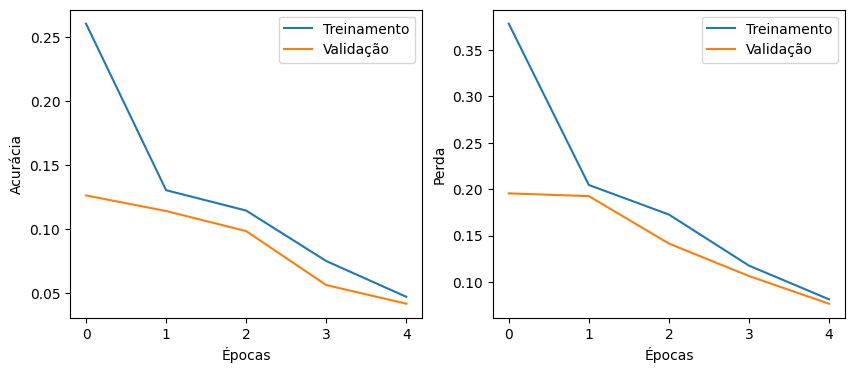

In [20]:
# Gráfico de treinamento
graph_2(history, 'mae')

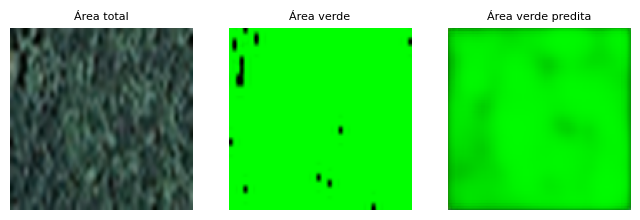

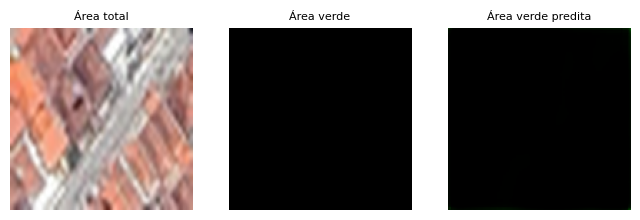

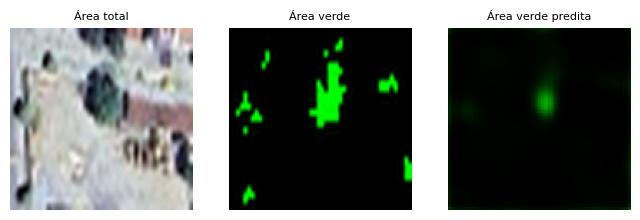

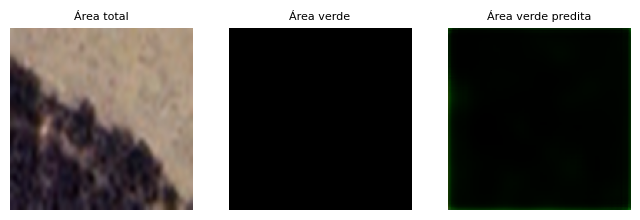

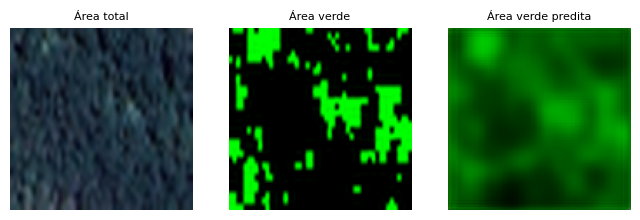

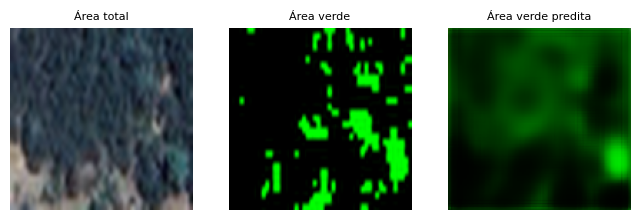

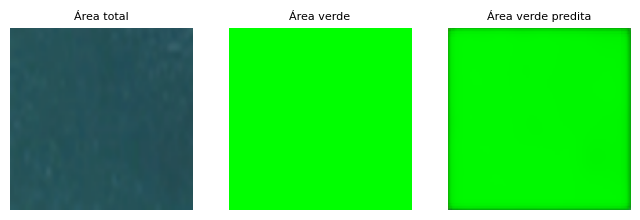

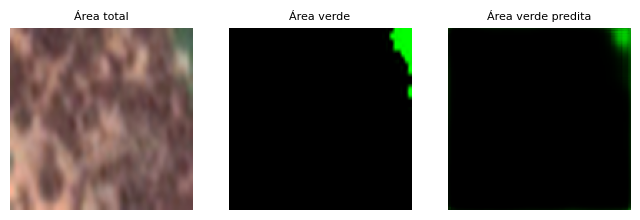

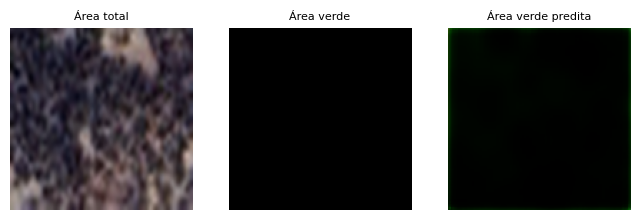

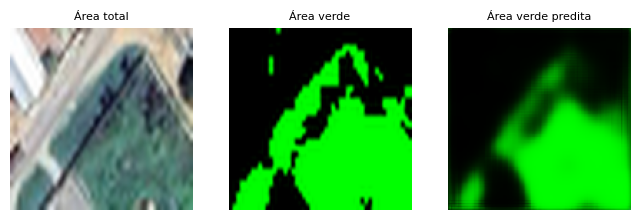

In [21]:
for i in range(30, 40):
        # Gráfico para comparação
        graph_1((images_test[i] * 255).astype(np.uint8), 'Área total',
                (labels_test[i] * 255).astype(np.uint8), 'Área verde',
                (predictions[i] * 255).astype(np.uint8), 'Área verde predita',
                (8, 5))

### Considerações Finais

---

Os dois modelos usados para treinar são parecidos, porém a principal diferença é no formato da saída, onde o modelo de percentual de áreas verdes produz números, e o modelo de predição produz imagens. Os resultados se mostraram promissores, contudo sofrem de *underfitting*, devido a pouca quantidade de imagens e de épocas para treinamento. O modelo de predição de imagens em especial possui alguns outros problemas relacionados à rotulação, e podem ser contornados com as mudanças nos rótulos descritas a seguir.

- Áreas totalmente verdes de florestas:
    - Imagens com 100% de cobertura verde.

- Áreas totalmente nao verdes de rios e mares:
    - Imagens com 0% de cobertura verde.

- Áreas totalmente nao verdes urbanas:
    - Imagens com 0% de cobertura verde.

- Áreas mescladas urbanas:
    - Imagens com x% de cobertura verde.

- Áreas mescladas rurais:
    - Imagens com x% de cobertura verde.

---